In [3]:
%matplotlib inline

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

def a3(wd_coefficient, n_hid, n_iters, learning_rate,
        momentum_multiplier, do_early_stopping, mini_batch_size):

    model = initial_model(n_hid)

    # Load data
    from_data_file = sio.loadmat('data.mat')['data']
    training_data = {}
    training_data['inputs'] = from_data_file[0][0]['training'][0][0]['inputs']
    training_data['targets'] = from_data_file[0][0]['training'][0][0]['targets']
    validation_data = {}
    validation_data['inputs'] = from_data_file[0][0]['validation'][0][0]['inputs']
    validation_data['targets'] = from_data_file[0][0]['validation'][0][0]['targets']
    test_data = {}
    test_data['inputs'] = from_data_file[0][0]['test'][0][0]['inputs']
    test_data['targets'] = from_data_file[0][0]['test'][0][0]['targets']

    n_training_cases = training_data['inputs'].shape[1]
    if n_iters != 0:
        test_gradient(model, training_data, wd_coefficient)

    # Optimization
    theta = model_to_theta(model)
    momentum_speed = theta * 0
    training_data_losses = []
    validation_data_losses = []
    best_so_far = {}
    if do_early_stopping:
        best_so_far['theta'] = -1 # this will be overwritten soon
        best_so_far['validation_loss'] = np.inf
        best_so_far['after_n_iters'] = -1

    for optimization_iteration_i in range(1,n_iters+1):
        model = theta_to_model(theta)
        training_batch = {}
        training_batch_start = ((optimization_iteration_i-1) * mini_batch_size)\
                               % n_training_cases + 1
        training_batch['inputs'] = training_data['inputs'][:,
            training_batch_start-1 : training_batch_start-1 + mini_batch_size ]
        training_batch['targets'] = training_data['targets'][:,
            training_batch_start-1 : training_batch_start-1 + mini_batch_size ]
        gradient = model_to_theta(d_loss_by_d_model(model,
                    training_batch, wd_coefficient))
        momentum_speed = momentum_speed * momentum_multiplier - gradient
        theta = theta + momentum_speed * learning_rate

        model = theta_to_model(theta)
        training_data_losses.append(loss(model, training_data, wd_coefficient))
        validation_data_losses.append(loss(model, validation_data, wd_coefficient))

        if do_early_stopping and \
            validation_data_losses[-1] < best_so_far['validation_loss']:
          best_so_far['theta'] = theta # this will be overwritten soon
          best_so_far['validation_loss'] = validation_data_losses[-1]
          best_so_far['after_n_iters'] = optimization_iteration_i

        if optimization_iteration_i % round(n_iters/10) == 0:
            print('After ', optimization_iteration_i, 'optimization iterations,'
                ' training data loss is', training_data_losses[-1],
                ', and validation data loss is ', validation_data_losses[-1])

    if n_iters != 0:
        # check again, this time with more typical parameters
        test_gradient(model, training_data, wd_coefficient)

    if do_early_stopping:
        print('Early stopping: validation loss was lowest after ',
            best_so_far['after_n_iters'],  'iterations. We chose the '
            'model that we had then.')
        theta = best_so_far['theta']


    # The optimization is finished. Now do some reporting.
    model = theta_to_model(theta)

    if n_iters != 0:
        plt.figure(1)
        plt.clf()
        plt.plot(range(n_iters),training_data_losses, 'b')
        plt.plot(range(n_iters),validation_data_losses, 'r')
        plt.legend(['training', 'validation'])
        plt.ylabel('loss')
        plt.xlabel('iteration number')
        plt.show()

    datas2 = [training_data, validation_data, test_data]
    data_names = ['training', 'validation', 'test']
    for data_i in range (0,3):
        data = datas2[data_i]
        data_name = data_names[data_i]
        print('The loss on the ', data_name, "data is ",
              loss(model, data, wd_coefficient))
        if wd_coefficient != 0:
            print('The classification loss (i.e. without weight decay) on the ',
                data_name, "data is ", loss(model, data, 0))
        print('The classification error rate on the', data_name, 'data is ',
            classification_performance(model, data))

def test_gradient(model, data, wd_coefficient):
    base_theta = model_to_theta(model)
    h = 0.01
    correctness_threshold = 0.00001
    analytic_gradient = model_to_theta(
                d_loss_by_d_model(model, data, wd_coefficient))
    # Test the gradient not for every element of theta, because that's
    # a lot of work. Test for only a few elements.
    for i in range(1,101):

        # 1299721 is prime and thus ensures a somewhat random-like
        # selection of indices
        test_index = (i * 1299721) % base_theta.shape[0]

        analytic_here = analytic_gradient[test_index]
        theta_step = base_theta * 0
        theta_step[test_index] = h
        contribution_distances = [-4, -3, -2, -1, 1, 2, 3, 4]
        contribution_weights = [1/280, -4/105, 1/5, -4/5, 4/5, -1/5, 4/105, -1/280]
        temp = 0
        for contribution_index in range(8):
            temp = temp + loss(theta_to_model(
                    base_theta +
                    theta_step * contribution_distances[contribution_index]),
                data,
                wd_coefficient) * contribution_weights[contribution_index]

        fd_here = temp / h
        diff = np.abs(analytic_here - fd_here)
        if diff < correctness_threshold:
            continue
        if diff / (np.abs(analytic_here) + np.abs(fd_here)) < \
                        correctness_threshold:
            continue

        print('Error! Theta element #', test_index+1 , ', with value ',
            base_theta[test_index], 'has finite difference gradient', fd_here,
            'but analytic gradient is', analytic_here,'That looks like an error.')
        quit()

    print('Gradient test passed. That means that the gradient that your '
          'code computed is within 0.001% of the gradient that the finite'
          ' difference approximation computed, so the gradient calculation'
          ' procedure is probably correct (not certainly, but probably).')

def logistic(input):
    return 1 / (1 + np.exp(-input))

def log_sum_exp_over_rows(a):
    # This computes log(sum(exp(a), axis=0)) in a numerically stable way
    maxs_small = np.reshape(np.amax(a, axis=0),(1,-1), order="F")
    maxs_big = np.tile(maxs_small, (a.shape[0], 1))
    ret = np.log(np.sum(np.exp(a - maxs_big), axis=0)) + maxs_small
    return ret

def loss(model, data, wd_coefficient):
    # model['input_to_hid'] is a matrix of size <number of hidden units> by
    # <number of inputs i.e. 256>. It contains the weights from the input
    # units to the hidden units.
    # model['hid_to_class'] is a matrix of size <number of classes i.e. 10>
    # by <number of hidden units>. It contains the weights from the hidden
    # units to the softmax units.
    # data['inputs'] is a matrix of size <number of inputs i.e. 256> by
    # <number of data cases>. Each column describes a different data case.
    # data['targets'] is a matrix of size <number of classes i.e. 10> by
    # <number of data cases>. Each column describes a different data case.
    # It contains a one-of-N encoding of the class, i.e. one element in
    # every column is 1 and the others are 0.

    # Before we can calculate the loss, we need to calculate a variety
    # of intermediate values, like the state of the hidden units.

    # input to the hidden units, i.e. before the logistic.
    # size: <number of hidden units> by <number of data cases>
    hid_input = np.dot(model['input_to_hid'], data['inputs'])

    # output of the hidden units, i.e. after the logistic.
    # size: <number of hidden units> by <number of data cases>
    hid_output = logistic(hid_input)

    # input to the components of the softmax.
    # size: <number of classes, i.e. 10> by <number of data cases>
    class_input = np.dot(model['hid_to_class'], hid_output)

    # The following three lines of code implement the softmax.
    # However, it's written differently from what the lectures say.
    # In the lectures, a softmax is described using an exponential
    # divided by a sum of exponentials.
    # What we do here is exactly equivalent (you can check the math or
    # just check it in practice), but this is more numerically stable.
    # "Numerically stable" means that this way, there will never be really
    # big numbers involved.
    # The exponential in the lectures can lead to really big numbers, which
    # are fine in mathematical equations, but can lead to all sorts of
    # problems in Octave.
    # Octave isn't well prepared to deal with really large numbers, like
    # the number 10 to the power 1000. Computations with such numbers get
    # unstable, so we avoid them.

    # log(sum(exp of class_input)) is what we subtract to get properly
    # normalized log class probabilities. size: <1> by <number of data cases>
    class_normalizer = log_sum_exp_over_rows(class_input)

    # log of probability of each class. size: <number of classes, i.e. 10>
    # by <number of data cases>
    log_class_prob = class_input - \
                     np.tile(class_normalizer, (class_input.shape[0], 1))

    # probability of each class. Each column (i.e. each case) sums to 1.
    # size: <number of classes, i.e. 10> by <number of data cases>
    class_prob = np.exp(log_class_prob)

    # select the right log class probability using that sum; then take the
    # mean over all data cases.
    classification_loss = -np.mean(np.sum(log_class_prob * data['targets'],
                                          axis=0))

    # weight decay loss. very straightforward: E = 1/2 * wd_coeffecient * theta^2
    wd_loss = np.sum(model_to_theta(model)*model_to_theta(model))/2*wd_coefficient

    ret = classification_loss + wd_loss

    return ret

def model_to_theta(model):
    # This function takes a model (or gradient in model form),
    # and turns it into one long vector. See also theta_to_model.
    input_to_hid_transpose = np.transpose(model['input_to_hid'])
    hid_to_class_transpose = np.transpose(model['hid_to_class'])

    ret = np.concatenate((input_to_hid_transpose.flatten('F'),
                          hid_to_class_transpose.flatten('F')), axis=0)
    return ret

def theta_to_model(theta):
    # This function takes a model (or gradient) in the form of one long
    # vector (maybe produced by model_to_theta), and restores it to the
    # structure format, i.e. with fields .input_to_hid and .hid_to_class,
    # both matrices.

    ret = {}

    n_hid = int(theta.shape[0] / (256+10))
    ret['input_to_hid'] = np.transpose(np.reshape(
                    theta[0:256*n_hid],(256, n_hid), order="F"))
    ret['hid_to_class'] = np.transpose(
            np.reshape(theta[256*n_hid:theta.shape[0]], (n_hid, 10), order="F"))

    return ret

def initial_model(n_hid):
    n_params = (256+10) * n_hid
    as_row_vector = np.cos(np.asarray(range(n_params)))

    # We don't use random initialization, for this assignment.
    # This way, everybody will get the same results.
    ret = theta_to_model(as_row_vector * 0.1)
    return ret

def classification_performance(model, data):
    # This returns the fraction of data cases that is incorrectly
    # classified by the model.

    # input to the hidden units, i.e. before the logistic.
    # size: <number of hidden units> by <number of data cases>
    hid_input = np.dot(model['input_to_hid'], data['inputs'])

    # output of the hidden units, i.e. after the logistic.
    # size: <number of hidden units> by <number of data cases>
    hid_output = logistic(hid_input)

    # input to the components of the softmax. size: <number of classes,
    # i.e. 10> by <number of data cases>
    class_input = np.dot(model['hid_to_class'], hid_output)

    # choices is integer: the chosen class, plus 1.
    choices = np.argmax(class_input, axis=0)

    # targets is integer: the target class, plus 1.
    targets = np.argmax(data['targets'], axis=0)

    sumtmp = 0.
    for i in range(choices.shape[0]):
        if choices[i] != targets[i]:
            sumtmp = sumtmp + 1.
        else:
            sumtmp = sumtmp + 0.

    ret = sumtmp / choices.shape[0]
    return ret

In [1]:
def d_loss_by_d_model(model, data, wd_coefficient):
    # model['input_to_hid'] is a matrix of size <number of hidden units>
    # by <number of inputs i.e. 256>
    # model['hid_to_class'] is a matrix of size <number of classes i.e. 10>
    # by <number of hidden units>
    # data['inputs'] is a matrix of size <number of inputs i.e. 256> by
    # <number of data cases>. Each column describes a different data case.
    # data['targets'] is a matrix of size <number of classes i.e. 10> by
    # <number of data cases>. Each column describes a different data case.
    # It contains a one-of-N encoding of the class, i.e. one element in
    # every column is 1 and the others are 0.
    #
    # The returned object is supposed to be exactly like parameter <model>,
    # i.e. it has fields ret.input_to_hid and ret.hid_to_class. However,
    # the contents of those matrices are gradients (d loss by d model
    # parameter), instead of model parameters.
    #
    # This is the only function that you're expected to change. Right now,
    # it just returns a lot of zeros, which is obviously not the correct
    # output. Your job is to replace that by a correct computation.
    
    ret = {}
    dcdwih =np.zeros(model['input_to_hid'].shape)
    dcdwhs =np.zeros(model['hid_to_class'].shape)
    #print(dcdwih.shape)
    number_of_cases = len(data['targets'][0])  
    #print (number_of_cases)
    for j in range(number_of_cases):
        #print (data['inputs'])
        #print (data['inputs'].transpose()[j])
        X = data['inputs'].transpose()[j]
        h = model['input_to_hid']@X
        #print(len(h))
        a=1/(1+np.exp(-h))
        #print(a.shape)
        #for i in range(len(model['input_to_hid'])):
        #    a.append(logistic(sum(h)))
            #print(a)d_loss_by_d_model
        #print(model['hid_to_class'])
        z = np.dot(model['hid_to_class'],a)
        #print(z.shape)
        y = np.exp(z)/sum(np.exp(z))
        t = data['targets'].transpose()[j]
        #print(t)
        dcdwhs = dcdwhs + np.outer((y-t),a)
        dcdwih = dcdwih + np.outer((y-t) @ model['hid_to_class'],(a*(1-a)@X))
        #dcdwih = dcdwih + np.outer((y-t) @ (np.outer((y-t),a)),(a@(1-a)*X))
    #print(y)
    dcdwhs = dcdwhs / number_of_cases
    dcdwih = dcdwih / number_of_cases
    #print(((y-t) @ model['hid_to_class']).shape)
    #print((a@(1-a)*X).shape)
    #print(np.outer((y-t) @ model['hid_to_class'],(a@(1-a)*X)).shape)
    ret['input_to_hid'] = dcdwih + model['input_to_hid'] * wd_coefficient
    ret['hid_to_class'] = dcdwhs + model['hid_to_class'] * wd_coefficient
#     ret['input_to_hid'] = dcdwih + dcdwih * wd_coefficient
#     ret['hid_to_class'] = dcdwhs + dcdwhs * wd_coefficient
    #print(model['input_to_hid'][0])
    #print(len(model['input_to_hid']))
    return ret

In [7]:
def d_loss_by_d_model(model, data, wd_coefficient):
    # model['input_to_hid'] is a matrix of size <number of hidden units>
    # by <number of inputs i.e. 256>
    # model['hid_to_class'] is a matrix of size <number of classes i.e. 10>
    # by <number of hidden units>
    # data['inputs'] is a matrix of size <number of inputs i.e. 256> by
    # <number of data cases>. Each column describes a different data case.
    # data['targets'] is a matrix of size <number of classes i.e. 10> by
    # <number of data cases>. Each column describes a different data case.
    # It contains a one-of-N encoding of the class, i.e. one element in
    # every column is 1 and the others are 0.
    #
    # The returned object is supposed to be exactly like parameter <model>,
    # i.e. it has fields ret.input_to_hid and ret.hid_to_class. However,
    # the contents of those matrices are gradients (d loss by d model
    # parameter), instead of model parameters.
    #
    # This is the only function that you're expected to change. Right now,
    # it just returns a lot of zeros, which is obviously not the correct
    # output. Your job is to replace that by a correct computation.
    
    ret = {}
    W1 = model['input_to_hid']
    W2 = model['hid_to_class']
    X = data['inputs']
    Y = data['targets']
    m = X.shape[1]
    Z1 = W1@X
    A1 = 1/(1+np.exp(-Z1))
    Z2 = W2@A1
    A2 = np.exp(Z2)/np.sum(np.exp(Z2))
    
#     print("### Z1 shape  ",Z1.shape)
#     print("### A1 shape  ",A1.shape)
#     print("### Z2 shape  ",Z2.shape)
#     print("### A2 shape  ",A2.shape)
#     print("### W1 shape  ",W1.shape)
#     print("### W2 shape  ",W2.shape)
    
    dZ2 = A2-Y
    print("### dZ2 shape  ",dZ2.shape)
    dW2 = 1/m*(dZ2@A1.T)
    print("### dW2 shape  ",dW2.shape)
    dCdZ = dZ2
    dZdH = W2.T@(np.multiply(A1,(1-A1)))
    dHdW1 = X
    
    print("### dCdZ shape  ",dCdZ.shape)
    print("### dZdH shape  ",dZdH.shape)
    print("### dHdW1 shape  ",dHdW1.shape)
    
    dW1 = np.multiply(dCdZ,dZdH)@dHdW1.T
    
#     dZ1 = np.multiply(W2.T@dZ2,np.multiply(A1,(1-A1)))
#     print("### dZ1 shape  ",dZ1.shape)
#     dW1 = 1/m*(dZ1@X.T)
#     print("### dW1 shape  ",dW1.shape)
    
    ret['input_to_hid'] = dW1 + W1 * wd_coefficient
    ret['hid_to_class'] = dW2 + W2 * wd_coefficient
#     ret['input_to_hid'] = dcdwih + dcdwih * wd_coefficient
#     ret['hid_to_class'] = dcdwhs + dcdwhs * wd_coefficient
    #print(model['input_to_hid'][0])
    #print(len(model['input_to_hid']))
    return ret

In [8]:
a3(0, 11, 70, 0.005, 0, False, 4)

### dZ2 shape   (10, 1000)
### dW2 shape   (10, 11)


ValueError: shapes (11,10) and (11,1000) not aligned: 10 (dim 1) != 11 (dim 0)

momentum 0.0 lr 0.002
Error! Theta element # 1642 , with value  0.046369533543 has finite difference gradient -0.00269888772205 but analytic gradient is -0.00239817218968 That looks like an error.
Error! Theta element # 623 , with value  0.0999375415997 has finite difference gradient -0.000629245939724 but analytic gradient is -0.000913382230768 That looks like an error.
Error! Theta element # 2264 , with value  0.0494715045845 has finite difference gradient 0.00129069669896 but analytic gradient is 0.000739631114562 That looks like an error.
Error! Theta element # 1245 , with value  0.0997502444198 has finite difference gradient -0.0009895107284 but analytic gradient is -0.000777438684815 That looks like an error.
Error! Theta element # 226 , with value  0.036731936773 has finite difference gradient -0.000833860505686 but analytic gradient is -0.000663235505639 That looks like an error.
Error! Theta element # 1867 , with value  0.0994383424259 has finite difference gradient -0.0007613

Error! Theta element # 2476 , with value  0.0839186304548 has finite difference gradient -0.000443521268771 but analytic gradient is -0.000707034815063 That looks like an error.
Error! Theta element # 1457 , with value  -0.0127844102569 has finite difference gradient -0.000609187460835 but analytic gradient is -0.00042181449915 That looks like an error.
Error! Theta element # 438 , with value  -0.0949668255372 has finite difference gradient -0.00216526418477 but analytic gradient is -0.00249859639333 That looks like an error.
Error! Theta element # 2079 , with value  -0.0162812330626 has finite difference gradient 0.00053577734044 but analytic gradient is -0.000225845061285 That looks like an error.
Error! Theta element # 1060 , with value  -0.0960145014326 has finite difference gradient -0.000156011650263 but analytic gradient is 4.7187379504e-05 That looks like an error.
Error! Theta element # 41 , with value  -0.0666938061652 has finite difference gradient 0.00240651998942 but analy

After  56 optimization iterations, training data loss is 2.30449316855 , and validation data loss is  2.30454129769
After  63 optimization iterations, training data loss is 2.30446303748 , and validation data loss is  2.30451523435
After  70 optimization iterations, training data loss is 2.30443826983 , and validation data loss is  2.30449021796
Error! Theta element # 1642 , with value  0.0467127898675 has finite difference gradient -0.00270090208099 but analytic gradient is -0.0028879139757 That looks like an error.
Error! Theta element # 623 , with value  0.100014658651 has finite difference gradient -0.000631298676854 but analytic gradient is -0.00114875119203 That looks like an error.
Error! Theta element # 2264 , with value  0.0493863279034 has finite difference gradient 0.001281287646 but analytic gradient is 0.000285010996458 That looks like an error.
Error! Theta element # 1245 , with value  0.0999721815759 has finite difference gradient -0.000988034224251 but analytic gradient

Error! Theta element # 1854 , with value  0.0858051442695 has finite difference gradient 0.00023328796157 but analytic gradient is -0.000678783824552 That looks like an error.
Error! Theta element # 835 , with value  -0.00916776994195 has finite difference gradient -0.000399008081162 but analytic gradient is -0.000793311504716 That looks like an error.
Error! Theta element # 2476 , with value  0.0839755102043 has finite difference gradient -0.000446503871813 but analytic gradient is -0.00105426144277 That looks like an error.
Error! Theta element # 1457 , with value  -0.0126501758408 has finite difference gradient -0.000610956894431 but analytic gradient is -0.000578773801123 That looks like an error.
Error! Theta element # 438 , with value  -0.0945824730971 has finite difference gradient -0.00216296825862 but analytic gradient is -0.00288990995132 That looks like an error.
Error! Theta element # 2079 , with value  -0.0162247083775 has finite difference gradient 0.0005289449402 but ana

Error! Theta element # 1841 , with value  0.0562568434829 has finite difference gradient 1.22200967895e-05 but analytic gradient is -4.88765598798e-05 That looks like an error.
Gradient test passed. That means that the gradient that your code computed is within 0.001% of the gradient that the finite difference approximation computed, so the gradient calculation procedure is probably correct (not certainly, but probably).


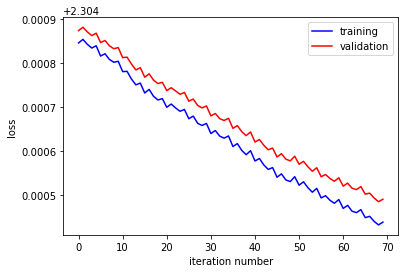

The loss on the  training data is  2.30443826983
The classification error rate on the training data is  0.9
The loss on the  validation data is  2.30449021796
The classification error rate on the validation data is  0.9
The loss on the  test data is  2.30450639302
The classification error rate on the test data is  0.9
momentum 0.0 lr 0.01
Error! Theta element # 1642 , with value  0.046369533543 has finite difference gradient -0.00269888772205 but analytic gradient is -0.00239817218968 That looks like an error.
Error! Theta element # 623 , with value  0.0999375415997 has finite difference gradient -0.000629245939724 but analytic gradient is -0.000913382230768 That looks like an error.
Error! Theta element # 2264 , with value  0.0494715045845 has finite difference gradient 0.00129069669896 but analytic gradient is 0.000739631114562 That looks like an error.
Error! Theta element # 1245 , with value  0.0997502444198 has finite difference gradient -0.0009895107284 but analytic gradient is -

Error! Theta element # 1232 , with value  0.0875503160999 has finite difference gradient -0.00013777727799 but analytic gradient is -0.000104864550805 That looks like an error.
Error! Theta element # 213 , with value  -0.00574724308477 has finite difference gradient 3.89529835276e-05 but analytic gradient is 0.000191581795268 That looks like an error.
Error! Theta element # 1854 , with value  0.0857880551242 has finite difference gradient 0.000240479684702 but analytic gradient is -8.71666203671e-05 That looks like an error.
Error! Theta element # 835 , with value  -0.00927161757483 has finite difference gradient -0.000399695466356 but analytic gradient is -0.000524671245129 That looks like an error.
Error! Theta element # 2476 , with value  0.0839186304548 has finite difference gradient -0.000443521268771 but analytic gradient is -0.000707034815063 That looks like an error.
Error! Theta element # 1457 , with value  -0.0127844102569 has finite difference gradient -0.000609187460835 but

After  14 optimization iterations, training data loss is 2.30429020605 , and validation data loss is  2.30435282537
After  21 optimization iterations, training data loss is 2.30404327277 , and validation data loss is  2.30412521034
After  28 optimization iterations, training data loss is 2.30386935744 , and validation data loss is  2.30396359148
After  35 optimization iterations, training data loss is 2.30373312085 , and validation data loss is  2.3038251836
After  42 optimization iterations, training data loss is 2.30349663518 , and validation data loss is  2.30360176614
After  49 optimization iterations, training data loss is 2.30325100843 , and validation data loss is  2.30337545207
After  56 optimization iterations, training data loss is 2.30308471051 , and validation data loss is  2.30321333608
After  63 optimization iterations, training data loss is 2.30294908502 , and validation data loss is  2.30309686557
After  70 optimization iterations, training data loss is 2.3028427815 , a

Error! Theta element # 213 , with value  -0.00540261108241 has finite difference gradient 3.06698277356e-05 but analytic gradient is -0.00237502919691 That looks like an error.
Error! Theta element # 1854 , with value  0.0864781947316 has finite difference gradient 0.000210885670114 but analytic gradient is -0.00305045167482 That looks like an error.
Error! Theta element # 835 , with value  -0.00851954806047 has finite difference gradient -0.00039657009639 but analytic gradient is -0.00187345132172 That looks like an error.
Error! Theta element # 2476 , with value  0.0844973501305 has finite difference gradient -0.000457862554193 but analytic gradient is -0.0024491184877 That looks like an error.
Error! Theta element # 1457 , with value  -0.0119346990886 has finite difference gradient -0.000620233292994 but analytic gradient is -0.0012124933673 That looks like an error.
Error! Theta element # 438 , with value  -0.0925911746497 has finite difference gradient -0.00215350263548 but analyt

Error! Theta element # 1841 , with value  0.0562829195174 has finite difference gradient 1.03092771151e-05 but analytic gradient is -0.00020816289295 That looks like an error.
Gradient test passed. That means that the gradient that your code computed is within 0.001% of the gradient that the finite difference approximation computed, so the gradient calculation procedure is probably correct (not certainly, but probably).


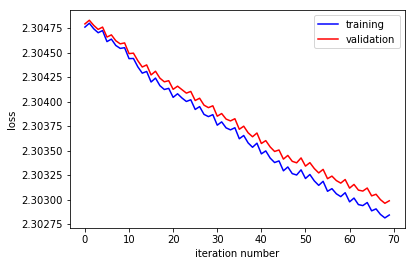

The loss on the  training data is  2.3028427815
The classification error rate on the training data is  0.879
The loss on the  validation data is  2.30298785778
The classification error rate on the validation data is  0.883
The loss on the  test data is  2.30294964929
The classification error rate on the test data is  0.8843333333333333
momentum 0.0 lr 0.05
Error! Theta element # 1642 , with value  0.046369533543 has finite difference gradient -0.00269888772205 but analytic gradient is -0.00239817218968 That looks like an error.
Error! Theta element # 623 , with value  0.0999375415997 has finite difference gradient -0.000629245939724 but analytic gradient is -0.000913382230768 That looks like an error.
Error! Theta element # 2264 , with value  0.0494715045845 has finite difference gradient 0.00129069669896 but analytic gradient is 0.000739631114562 That looks like an error.
Error! Theta element # 1245 , with value  0.0997502444198 has finite difference gradient -0.0009895107284 but anal

Error! Theta element # 1232 , with value  0.0875503160999 has finite difference gradient -0.00013777727799 but analytic gradient is -0.000104864550805 That looks like an error.
Error! Theta element # 213 , with value  -0.00574724308477 has finite difference gradient 3.89529835276e-05 but analytic gradient is 0.000191581795268 That looks like an error.
Error! Theta element # 1854 , with value  0.0857880551242 has finite difference gradient 0.000240479684702 but analytic gradient is -8.71666203671e-05 That looks like an error.
Error! Theta element # 835 , with value  -0.00927161757483 has finite difference gradient -0.000399695466356 but analytic gradient is -0.000524671245129 That looks like an error.
Error! Theta element # 2476 , with value  0.0839186304548 has finite difference gradient -0.000443521268771 but analytic gradient is -0.000707034815063 That looks like an error.
Error! Theta element # 1457 , with value  -0.0127844102569 has finite difference gradient -0.000609187460835 but

After  7 optimization iterations, training data loss is 2.30380884228 , and validation data loss is  2.30391822062
After  14 optimization iterations, training data loss is 2.30220240969 , and validation data loss is  2.30240389606
After  21 optimization iterations, training data loss is 2.30108735683 , and validation data loss is  2.30137499533
After  28 optimization iterations, training data loss is 2.30033669935 , and validation data loss is  2.30067403813
After  35 optimization iterations, training data loss is 2.29984845854 , and validation data loss is  2.30015927904
After  42 optimization iterations, training data loss is 2.29905913543 , and validation data loss is  2.29941008632
After  49 optimization iterations, training data loss is 2.29804226563 , and validation data loss is  2.29847776801
After  56 optimization iterations, training data loss is 2.29748622435 , and validation data loss is  2.29788916868
After  63 optimization iterations, training data loss is 2.29741372336 , 

Error! Theta element # 213 , with value  0.00903296106426 has finite difference gradient 0.000135753758717 but analytic gradient is -0.0116120440312 That looks like an error.
Error! Theta element # 1854 , with value  0.103965330847 has finite difference gradient 0.000212253922807 but analytic gradient is -0.0140742009379 That looks like an error.
Error! Theta element # 835 , with value  0.000206222369554 has finite difference gradient -0.000320932524397 but analytic gradient is -0.00672345403449 That looks like an error.
Error! Theta element # 2476 , with value  0.0940641145358 has finite difference gradient -0.000443820943722 but analytic gradient is -0.00861579432186 That looks like an error.
Error! Theta element # 1457 , with value  -0.00439771310523 has finite difference gradient -0.000545478303027 but analytic gradient is -0.00386933068446 That looks like an error.
Error! Theta element # 438 , with value  -0.0721524431469 has finite difference gradient -0.00182741488298 but analyt

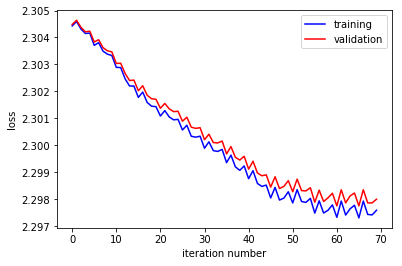

The loss on the  training data is  2.29759245389
The classification error rate on the training data is  0.9
The loss on the  validation data is  2.29800091077
The classification error rate on the validation data is  0.9
The loss on the  test data is  2.29785042378
The classification error rate on the test data is  0.9
momentum 0.0 lr 0.2
Error! Theta element # 1642 , with value  0.046369533543 has finite difference gradient -0.00269888772205 but analytic gradient is -0.00239817218968 That looks like an error.
Error! Theta element # 623 , with value  0.0999375415997 has finite difference gradient -0.000629245939724 but analytic gradient is -0.000913382230768 That looks like an error.
Error! Theta element # 2264 , with value  0.0494715045845 has finite difference gradient 0.00129069669896 but analytic gradient is 0.000739631114562 That looks like an error.
Error! Theta element # 1245 , with value  0.0997502444198 has finite difference gradient -0.0009895107284 but analytic gradient is -0

Error! Theta element # 1007 , with value  0.0771022637656 has finite difference gradient -0.000267833040447 but analytic gradient is -0.000305353893477 That looks like an error.
Error! Theta element # 2648 , with value  -0.0206688688011 has finite difference gradient -0.00353717331513 but analytic gradient is -0.049758022437 That looks like an error.
Error! Theta element # 1629 , with value  0.0793044613967 has finite difference gradient 3.78687203815e-05 but analytic gradient is 0.000339522365437 That looks like an error.
Error! Theta element # 610 , with value  0.0892032120217 has finite difference gradient -0.00140135532166 but analytic gradient is -0.00168397058284 That looks like an error.
Error! Theta element # 2251 , with value  0.0814075944318 has finite difference gradient 0.000808471029154 but analytic gradient is 0.000355829920566 That looks like an error.
Error! Theta element # 1232 , with value  0.0875503160999 has finite difference gradient -0.00013777727799 but analytic 

After  7 optimization iterations, training data loss is 2.30195717814 , and validation data loss is  2.30230093703
After  14 optimization iterations, training data loss is 2.29762993502 , and validation data loss is  2.29832606903
After  21 optimization iterations, training data loss is 2.29636282097 , and validation data loss is  2.2971103791
After  28 optimization iterations, training data loss is 2.30255266445 , and validation data loss is  2.30325761831
After  35 optimization iterations, training data loss is 2.30566347631 , and validation data loss is  2.30613993732
After  42 optimization iterations, training data loss is 2.30197726805 , and validation data loss is  2.30215358142
After  49 optimization iterations, training data loss is 2.3080027179 , and validation data loss is  2.3085727699
After  56 optimization iterations, training data loss is 2.31812133316 , and validation data loss is  2.31860921772
After  63 optimization iterations, training data loss is 2.31666246536 , and

Error! Theta element # 1007 , with value  0.0959443955484 has finite difference gradient -4.99342183474e-05 but analytic gradient is -0.0016644008353 That looks like an error.
Error! Theta element # 2648 , with value  0.852683656994 has finite difference gradient 0.0249055579369 but analytic gradient is -0.0986123960378 That looks like an error.
Error! Theta element # 1629 , with value  0.157748438824 has finite difference gradient 0.000160698812987 but analytic gradient is -0.0057445725486 That looks like an error.
Error! Theta element # 610 , with value  0.138443211981 has finite difference gradient -0.000136273206711 but analytic gradient is -0.0032709730261 That looks like an error.
Error! Theta element # 2251 , with value  0.133003960497 has finite difference gradient -4.74654483912e-06 but analytic gradient is -0.00366506060995 That looks like an error.
Error! Theta element # 1232 , with value  0.095925833509 has finite difference gradient -1.27995264937e-05 but analytic gradient

Error! Theta element # 2238 , with value  0.14174784716 has finite difference gradient -1.09666947098e-05 but analytic gradient is -0.00350903288415 That looks like an error.
Error! Theta element # 1219 , with value  0.153237553338 has finite difference gradient 0.00010849721298 but analytic gradient is -0.00478949170821 That looks like an error.
Error! Theta element # 200 , with value  0.0114498476254 has finite difference gradient 5.49879452184e-05 but analytic gradient is -0.00334664222009 That looks like an error.
Error! Theta element # 1841 , with value  0.0632029894131 has finite difference gradient -1.49482334202e-06 but analytic gradient is -0.000831785690779 That looks like an error.
Gradient test passed. That means that the gradient that your code computed is within 0.001% of the gradient that the finite difference approximation computed, so the gradient calculation procedure is probably correct (not certainly, but probably).


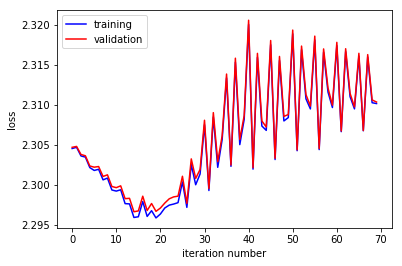

The loss on the  training data is  2.31017671646
The classification error rate on the training data is  0.9
The loss on the  validation data is  2.3103657761
The classification error rate on the validation data is  0.9
The loss on the  test data is  2.31028866987
The classification error rate on the test data is  0.9
momentum 0.0 lr 1.0
Error! Theta element # 1642 , with value  0.046369533543 has finite difference gradient -0.00269888772205 but analytic gradient is -0.00239817218968 That looks like an error.
Error! Theta element # 623 , with value  0.0999375415997 has finite difference gradient -0.000629245939724 but analytic gradient is -0.000913382230768 That looks like an error.
Error! Theta element # 2264 , with value  0.0494715045845 has finite difference gradient 0.00129069669896 but analytic gradient is 0.000739631114562 That looks like an error.
Error! Theta element # 1245 , with value  0.0997502444198 has finite difference gradient -0.0009895107284 but analytic gradient is -0.

Error! Theta element # 1232 , with value  0.0875503160999 has finite difference gradient -0.00013777727799 but analytic gradient is -0.000104864550805 That looks like an error.
Error! Theta element # 213 , with value  -0.00574724308477 has finite difference gradient 3.89529835276e-05 but analytic gradient is 0.000191581795268 That looks like an error.
Error! Theta element # 1854 , with value  0.0857880551242 has finite difference gradient 0.000240479684702 but analytic gradient is -8.71666203671e-05 That looks like an error.
Error! Theta element # 835 , with value  -0.00927161757483 has finite difference gradient -0.000399695466356 but analytic gradient is -0.000524671245129 That looks like an error.
Error! Theta element # 2476 , with value  0.0839186304548 has finite difference gradient -0.000443521268771 but analytic gradient is -0.000707034815063 That looks like an error.
Error! Theta element # 1457 , with value  -0.0127844102569 has finite difference gradient -0.000609187460835 but

After  35 optimization iterations, training data loss is 2.60771268763 , and validation data loss is  2.60769007141
After  42 optimization iterations, training data loss is 2.59502708155 , and validation data loss is  2.59480974366
After  49 optimization iterations, training data loss is 2.60161715527 , and validation data loss is  2.6017755401
After  56 optimization iterations, training data loss is 2.60303438734 , and validation data loss is  2.60320550911
After  63 optimization iterations, training data loss is 2.60677223075 , and validation data loss is  2.60687148886
After  70 optimization iterations, training data loss is 2.60595079483 , and validation data loss is  2.60591491986
Error! Theta element # 1642 , with value  0.257906736733 has finite difference gradient 1.20544391856e-05 but analytic gradient is -0.00101291028651 That looks like an error.
Error! Theta element # 623 , with value  0.184954821053 has finite difference gradient -6.82008811058e-07 but analytic gradient is

Error! Theta element # 2648 , with value  4.99688883907 has finite difference gradient 0.133468446055 but analytic gradient is -0.099735326277 That looks like an error.
Error! Theta element # 1629 , with value  0.236110445814 has finite difference gradient 1.89597858309e-05 but analytic gradient is -0.00124434863763 That looks like an error.
Error! Theta element # 610 , with value  0.193303891274 has finite difference gradient 2.33652108547e-06 but analytic gradient is -0.000820886676336 That looks like an error.
Error! Theta element # 2251 , with value  0.194280182101 has finite difference gradient 5.82721909771e-06 but analytic gradient is -0.000535416931818 That looks like an error.
Error! Theta element # 1232 , with value  0.105825298797 has finite difference gradient 8.47373485963e-07 but analytic gradient is -0.000173886098512 That looks like an error.
Error! Theta element # 213 , with value  0.150637201091 has finite difference gradient 1.3418703688e-05 but analytic gradient is 

Error! Theta element # 1841 , with value  0.0735398721288 has finite difference gradient 1.48076143309e-06 but analytic gradient is -0.000308746055025 That looks like an error.
Gradient test passed. That means that the gradient that your code computed is within 0.001% of the gradient that the finite difference approximation computed, so the gradient calculation procedure is probably correct (not certainly, but probably).


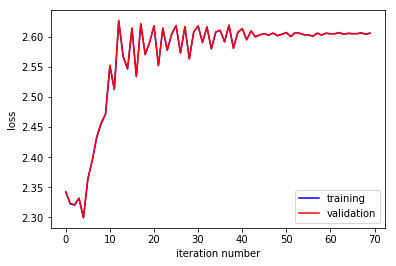

The loss on the  training data is  2.60595079483
The classification error rate on the training data is  0.899
The loss on the  validation data is  2.60591491986
The classification error rate on the validation data is  0.898
The loss on the  test data is  2.60583999312
The classification error rate on the test data is  0.8993333333333333
momentum 0.0 lr 5.0
Error! Theta element # 1642 , with value  0.046369533543 has finite difference gradient -0.00269888772205 but analytic gradient is -0.00239817218968 That looks like an error.
Error! Theta element # 623 , with value  0.0999375415997 has finite difference gradient -0.000629245939724 but analytic gradient is -0.000913382230768 That looks like an error.
Error! Theta element # 2264 , with value  0.0494715045845 has finite difference gradient 0.00129069669896 but analytic gradient is 0.000739631114562 That looks like an error.
Error! Theta element # 1245 , with value  0.0997502444198 has finite difference gradient -0.0009895107284 but anal

Error! Theta element # 2251 , with value  0.0814075944318 has finite difference gradient 0.000808471029154 but analytic gradient is 0.000355829920566 That looks like an error.
Error! Theta element # 1232 , with value  0.0875503160999 has finite difference gradient -0.00013777727799 but analytic gradient is -0.000104864550805 That looks like an error.
Error! Theta element # 213 , with value  -0.00574724308477 has finite difference gradient 3.89529835276e-05 but analytic gradient is 0.000191581795268 That looks like an error.
Error! Theta element # 1854 , with value  0.0857880551242 has finite difference gradient 0.000240479684702 but analytic gradient is -8.71666203671e-05 That looks like an error.
Error! Theta element # 835 , with value  -0.00927161757483 has finite difference gradient -0.000399695466356 but analytic gradient is -0.000524671245129 That looks like an error.
Error! Theta element # 2476 , with value  0.0839186304548 has finite difference gradient -0.000443521268771 but an

After  35 optimization iterations, training data loss is 10.833682529 , and validation data loss is  10.8335704196
After  42 optimization iterations, training data loss is 10.2883319653 , and validation data loss is  10.2882573031
After  49 optimization iterations, training data loss is 10.6869494038 , and validation data loss is  10.6869336046
After  56 optimization iterations, training data loss is 10.353985577 , and validation data loss is  10.3540126838
After  63 optimization iterations, training data loss is 10.5580323187 , and validation data loss is  10.5581469869
After  70 optimization iterations, training data loss is 10.5404666853 , and validation data loss is  10.5405012384
Error! Theta element # 1642 , with value  0.314160782599 has finite difference gradient 9.41904608337e-06 but analytic gradient is -0.000152701636985 That looks like an error.
Error! Theta element # 623 , with value  0.262323966695 has finite difference gradient 1.1179760652e-06 but analytic gradient is -

Error! Theta element # 385 , with value  0.10641678846 has finite difference gradient 1.34139287594e-06 but analytic gradient is -4.39238330251e-05 That looks like an error.
Error! Theta element # 2026 , with value  0.175957206722 has finite difference gradient 6.74624601876e-06 but analytic gradient is -0.000118009923257 That looks like an error.
Error! Theta element # 1007 , with value  0.265705117728 has finite difference gradient 3.23147363104e-06 but analytic gradient is -0.000136845068442 That looks like an error.
Error! Theta element # 2648 , with value  25.293096479 has finite difference gradient 0.89095317734 but analytic gradient is -0.0990078762076 That looks like an error.
Error! Theta element # 1629 , with value  0.36544117432 has finite difference gradient 1.7641420768e-05 but analytic gradient is -0.00028520689337 That looks like an error.
Error! Theta element # 610 , with value  0.338403275142 has finite difference gradient 1.98138861845e-06 but analytic gradient is -0.

Error! Theta element # 1841 , with value  0.0967541614511 has finite difference gradient 3.57326198283e-06 but analytic gradient is -8.25154727151e-05 That looks like an error.
Gradient test passed. That means that the gradient that your code computed is within 0.001% of the gradient that the finite difference approximation computed, so the gradient calculation procedure is probably correct (not certainly, but probably).


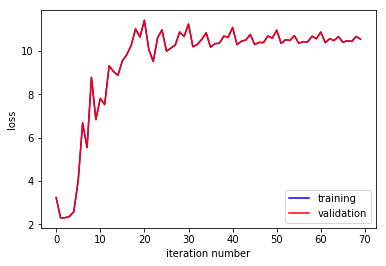

The loss on the  training data is  10.5404666853
The classification error rate on the training data is  0.9
The loss on the  validation data is  10.5405012384
The classification error rate on the validation data is  0.9
The loss on the  test data is  10.5402890484
The classification error rate on the test data is  0.9
momentum 0.0 lr 20.0
Error! Theta element # 1642 , with value  0.046369533543 has finite difference gradient -0.00269888772205 but analytic gradient is -0.00239817218968 That looks like an error.
Error! Theta element # 623 , with value  0.0999375415997 has finite difference gradient -0.000629245939724 but analytic gradient is -0.000913382230768 That looks like an error.
Error! Theta element # 2264 , with value  0.0494715045845 has finite difference gradient 0.00129069669896 but analytic gradient is 0.000739631114562 That looks like an error.
Error! Theta element # 1245 , with value  0.0997502444198 has finite difference gradient -0.0009895107284 but analytic gradient is -

Error! Theta element # 2476 , with value  0.0839186304548 has finite difference gradient -0.000443521268771 but analytic gradient is -0.000707034815063 That looks like an error.
Error! Theta element # 1457 , with value  -0.0127844102569 has finite difference gradient -0.000609187460835 but analytic gradient is -0.00042181449915 That looks like an error.
Error! Theta element # 438 , with value  -0.0949668255372 has finite difference gradient -0.00216526418477 but analytic gradient is -0.00249859639333 That looks like an error.
Error! Theta element # 2079 , with value  -0.0162812330626 has finite difference gradient 0.00053577734044 but analytic gradient is -0.000225845061285 That looks like an error.
Error! Theta element # 1060 , with value  -0.0960145014326 has finite difference gradient -0.000156011650263 but analytic gradient is 4.7187379504e-05 That looks like an error.
Error! Theta element # 41 , with value  -0.0666938061652 has finite difference gradient 0.00240651998942 but analy

After  35 optimization iterations, training data loss is 2.30164173539 , and validation data loss is  2.30212706576
After  42 optimization iterations, training data loss is 2.30149476608 , and validation data loss is  2.30201606691
After  49 optimization iterations, training data loss is 2.30147899091 , and validation data loss is  2.30200077992
After  56 optimization iterations, training data loss is 2.31738154226 , and validation data loss is  2.31672073033
After  63 optimization iterations, training data loss is 2.34387104883 , and validation data loss is  2.34015137471
After  70 optimization iterations, training data loss is 3.61357163004 , and validation data loss is  3.61849219476
Error! Theta element # 1245 , with value  0.531698042229 has finite difference gradient 6.40048009129e-05 but analytic gradient is -0.000119092325159 That looks like an error.
Error! Theta element # 848 , with value  0.0523193168738 has finite difference gradient -2.75636405089e-05 but analytic gradient

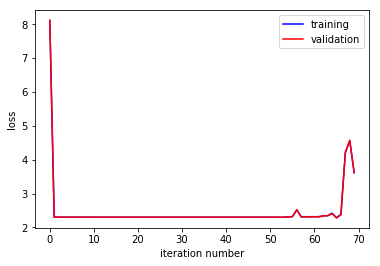

The loss on the  training data is  3.61357163004
The classification error rate on the training data is  0.9
The loss on the  validation data is  3.61849219476
The classification error rate on the validation data is  0.9
The loss on the  test data is  3.61316589187
The classification error rate on the test data is  0.9
momentum 0.9 lr 0.002
Error! Theta element # 1642 , with value  0.046369533543 has finite difference gradient -0.00269888772205 but analytic gradient is -0.00239817218968 That looks like an error.
Error! Theta element # 623 , with value  0.0999375415997 has finite difference gradient -0.000629245939724 but analytic gradient is -0.000913382230768 That looks like an error.
Error! Theta element # 2264 , with value  0.0494715045845 has finite difference gradient 0.00129069669896 but analytic gradient is 0.000739631114562 That looks like an error.
Error! Theta element # 1245 , with value  0.0997502444198 has finite difference gradient -0.0009895107284 but analytic gradient is 

Error! Theta element # 1457 , with value  -0.0127844102569 has finite difference gradient -0.000609187460835 but analytic gradient is -0.00042181449915 That looks like an error.
Error! Theta element # 438 , with value  -0.0949668255372 has finite difference gradient -0.00216526418477 but analytic gradient is -0.00249859639333 That looks like an error.
Error! Theta element # 2079 , with value  -0.0162812330626 has finite difference gradient 0.00053577734044 but analytic gradient is -0.000225845061285 That looks like an error.
Error! Theta element # 1060 , with value  -0.0960145014326 has finite difference gradient -0.000156011650263 but analytic gradient is 4.7187379504e-05 That looks like an error.
Error! Theta element # 41 , with value  -0.0666938061652 has finite difference gradient 0.00240651998942 but analytic gradient is 0.00254381929794 That looks like an error.
Error! Theta element # 1682 , with value  -0.0969422390846 has finite difference gradient 3.36966307435e-05 but analyti

After  63 optimization iterations, training data loss is 2.30158127294 , and validation data loss is  2.30180433563
After  70 optimization iterations, training data loss is 2.30129575087 , and validation data loss is  2.30153861801
Error! Theta element # 1642 , with value  0.0509903550484 has finite difference gradient -0.00272146110449 but analytic gradient is -0.00669633179621 That looks like an error.
Error! Theta element # 623 , with value  0.101207917444 has finite difference gradient -0.000651159418664 but analytic gradient is -0.00297854894652 That looks like an error.
Error! Theta element # 2264 , with value  0.0500702554462 has finite difference gradient 0.00121862021411 but analytic gradient is -0.00322176455716 That looks like an error.
Error! Theta element # 1245 , with value  0.102703409736 has finite difference gradient -0.000988113037495 but analytic gradient is -0.00344536326914 That looks like an error.
Error! Theta element # 226 , with value  0.0395545667816 has finit

Error! Theta element # 2251 , with value  0.0816887596458 has finite difference gradient 0.000745852709948 but analytic gradient is -0.00290055962733 That looks like an error.
Error! Theta element # 1232 , with value  0.0877767418978 has finite difference gradient -0.000141380712787 but analytic gradient is -0.000521819196791 That looks like an error.
Error! Theta element # 213 , with value  -0.00463466291581 has finite difference gradient 9.90769346374e-06 but analytic gradient is -0.0042932680178 That looks like an error.
Error! Theta element # 1854 , with value  0.0873501066905 has finite difference gradient 0.000188753263037 but analytic gradient is -0.00524947437953 That looks like an error.
Error! Theta element # 835 , with value  -0.00779543963743 has finite difference gradient -0.000371860398066 but analytic gradient is -0.00285771061316 That looks like an error.
Error! Theta element # 2476 , with value  0.0851545214109 has finite difference gradient -0.000468337795868 but anal

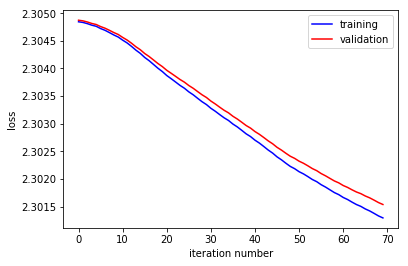

The loss on the  training data is  2.30129575087
The classification error rate on the training data is  0.9
The loss on the  validation data is  2.30153861801
The classification error rate on the validation data is  0.9
The loss on the  test data is  2.30143567691
The classification error rate on the test data is  0.9
momentum 0.9 lr 0.01
Error! Theta element # 1642 , with value  0.046369533543 has finite difference gradient -0.00269888772205 but analytic gradient is -0.00239817218968 That looks like an error.
Error! Theta element # 623 , with value  0.0999375415997 has finite difference gradient -0.000629245939724 but analytic gradient is -0.000913382230768 That looks like an error.
Error! Theta element # 2264 , with value  0.0494715045845 has finite difference gradient 0.00129069669896 but analytic gradient is 0.000739631114562 That looks like an error.
Error! Theta element # 1245 , with value  0.0997502444198 has finite difference gradient -0.0009895107284 but analytic gradient is -

Error! Theta element # 1232 , with value  0.0875503160999 has finite difference gradient -0.00013777727799 but analytic gradient is -0.000104864550805 That looks like an error.
Error! Theta element # 213 , with value  -0.00574724308477 has finite difference gradient 3.89529835276e-05 but analytic gradient is 0.000191581795268 That looks like an error.
Error! Theta element # 1854 , with value  0.0857880551242 has finite difference gradient 0.000240479684702 but analytic gradient is -8.71666203671e-05 That looks like an error.
Error! Theta element # 835 , with value  -0.00927161757483 has finite difference gradient -0.000399695466356 but analytic gradient is -0.000524671245129 That looks like an error.
Error! Theta element # 2476 , with value  0.0839186304548 has finite difference gradient -0.000443521268771 but analytic gradient is -0.000707034815063 That looks like an error.
Error! Theta element # 1457 , with value  -0.0127844102569 has finite difference gradient -0.000609187460835 but

After  21 optimization iterations, training data loss is 2.30025842272 , and validation data loss is  2.30061175797
After  28 optimization iterations, training data loss is 2.2984929601 , and validation data loss is  2.29896380766
After  35 optimization iterations, training data loss is 2.29693362496 , and validation data loss is  2.29744825958
After  42 optimization iterations, training data loss is 2.29567626869 , and validation data loss is  2.29622962884
After  49 optimization iterations, training data loss is 2.29469651579 , and validation data loss is  2.29529271801
After  56 optimization iterations, training data loss is 2.29466585587 , and validation data loss is  2.29523947545
After  63 optimization iterations, training data loss is 2.29530333038 , and validation data loss is  2.29583615205
After  70 optimization iterations, training data loss is 2.2963305171 , and validation data loss is  2.29680391564
Error! Theta element # 1642 , with value  0.0974090010815 has finite diffe

Error! Theta element # 2251 , with value  0.0996526884025 has finite difference gradient 0.000230304327156 but analytic gradient is -0.00955414303811 That looks like an error.
Error! Theta element # 1232 , with value  0.0909482509367 has finite difference gradient -8.77704529742e-05 but analytic gradient is -0.00127538581612 That looks like an error.
Error! Theta element # 213 , with value  0.026806486909 has finite difference gradient 0.000119509969928 but analytic gradient is -0.0121631940042 That looks like an error.
Error! Theta element # 1854 , with value  0.125469952291 has finite difference gradient 4.88500842215e-05 but analytic gradient is -0.0156720369841 That looks like an error.
Error! Theta element # 835 , with value  0.0103512195999 has finite difference gradient -8.89013182563e-05 but analytic gradient is -0.00692045682554 That looks like an error.
Error! Theta element # 2476 , with value  0.106376110165 has finite difference gradient -0.000273590725581 but analytic grad

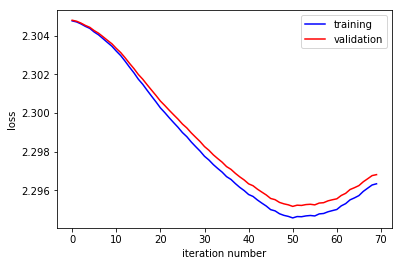

The loss on the  training data is  2.2963305171
The classification error rate on the training data is  0.826
The loss on the  validation data is  2.29680391564
The classification error rate on the validation data is  0.833
The loss on the  test data is  2.296630565
The classification error rate on the test data is  0.8341111111111111
momentum 0.9 lr 0.05
Error! Theta element # 1642 , with value  0.046369533543 has finite difference gradient -0.00269888772205 but analytic gradient is -0.00239817218968 That looks like an error.
Error! Theta element # 623 , with value  0.0999375415997 has finite difference gradient -0.000629245939724 but analytic gradient is -0.000913382230768 That looks like an error.
Error! Theta element # 2264 , with value  0.0494715045845 has finite difference gradient 0.00129069669896 but analytic gradient is 0.000739631114562 That looks like an error.
Error! Theta element # 1245 , with value  0.0997502444198 has finite difference gradient -0.0009895107284 but analyt

Error! Theta element # 610 , with value  0.0892032120217 has finite difference gradient -0.00140135532166 but analytic gradient is -0.00168397058284 That looks like an error.
Error! Theta element # 2251 , with value  0.0814075944318 has finite difference gradient 0.000808471029154 but analytic gradient is 0.000355829920566 That looks like an error.
Error! Theta element # 1232 , with value  0.0875503160999 has finite difference gradient -0.00013777727799 but analytic gradient is -0.000104864550805 That looks like an error.
Error! Theta element # 213 , with value  -0.00574724308477 has finite difference gradient 3.89529835276e-05 but analytic gradient is 0.000191581795268 That looks like an error.
Error! Theta element # 1854 , with value  0.0857880551242 has finite difference gradient 0.000240479684702 but analytic gradient is -8.71666203671e-05 That looks like an error.
Error! Theta element # 835 , with value  -0.00927161757483 has finite difference gradient -0.000399695466356 but analy

After  21 optimization iterations, training data loss is 2.29328482537 , and validation data loss is  2.29429227156
After  28 optimization iterations, training data loss is 2.29988311077 , and validation data loss is  2.30058664347
After  35 optimization iterations, training data loss is 2.30923669918 , and validation data loss is  2.30967944096
After  42 optimization iterations, training data loss is 2.31202964269 , and validation data loss is  2.31227621861
After  49 optimization iterations, training data loss is 2.30600126555 , and validation data loss is  2.30616796936
After  56 optimization iterations, training data loss is 2.3035362937 , and validation data loss is  2.30364528631
After  63 optimization iterations, training data loss is 2.30253979661 , and validation data loss is  2.30260174564
After  70 optimization iterations, training data loss is 2.30309734569 , and validation data loss is  2.30314448806
Error! Theta element # 1642 , with value  0.216863950487 has finite diffe

Error! Theta element # 2476 , with value  0.170334817042 has finite difference gradient -6.85769891845e-06 but analytic gradient is -0.00100626525481 That looks like an error.
Error! Theta element # 1457 , with value  0.0397045100265 has finite difference gradient 2.10496277631e-06 but analytic gradient is -0.000631516931559 That looks like an error.
Error! Theta element # 438 , with value  0.0669343367157 has finite difference gradient -1.88317245967e-05 but analytic gradient is -0.00144703589717 That looks like an error.
Error! Theta element # 2079 , with value  0.192654570732 has finite difference gradient -1.18080926306e-05 but analytic gradient is -0.0029616685266 That looks like an error.
Error! Theta element # 1060 , with value  -0.0264390064157 has finite difference gradient 2.43415972059e-05 but analytic gradient is -0.00141104272713 That looks like an error.
Error! Theta element # 41 , with value  0.0247378894395 has finite difference gradient 6.14148987372e-05 but analytic g

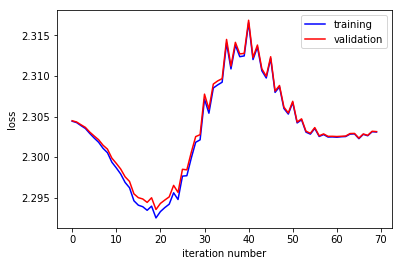

The loss on the  training data is  2.30309734569
The classification error rate on the training data is  0.899
The loss on the  validation data is  2.30314448806
The classification error rate on the validation data is  0.899
The loss on the  test data is  2.3031090216
The classification error rate on the test data is  0.8978888888888888
momentum 0.9 lr 0.2
Error! Theta element # 1642 , with value  0.046369533543 has finite difference gradient -0.00269888772205 but analytic gradient is -0.00239817218968 That looks like an error.
Error! Theta element # 623 , with value  0.0999375415997 has finite difference gradient -0.000629245939724 but analytic gradient is -0.000913382230768 That looks like an error.
Error! Theta element # 2264 , with value  0.0494715045845 has finite difference gradient 0.00129069669896 but analytic gradient is 0.000739631114562 That looks like an error.
Error! Theta element # 1245 , with value  0.0997502444198 has finite difference gradient -0.0009895107284 but analy

Error! Theta element # 2079 , with value  -0.0162812330626 has finite difference gradient 0.00053577734044 but analytic gradient is -0.000225845061285 That looks like an error.
Error! Theta element # 1060 , with value  -0.0960145014326 has finite difference gradient -0.000156011650263 but analytic gradient is 4.7187379504e-05 That looks like an error.
Error! Theta element # 41 , with value  -0.0666938061652 has finite difference gradient 0.00240651998942 but analytic gradient is 0.00254381929794 That looks like an error.
Error! Theta element # 1682 , with value  -0.0969422390846 has finite difference gradient 3.36966307435e-05 but analytic gradient is 0.000191949026478 That looks like an error.
Error! Theta element # 663 , with value  -0.0640190655386 has finite difference gradient 0.000943399089293 but analytic gradient is 0.000419954467525 That looks like an error.
Error! Theta element # 2304 , with value  -0.0977488795931 has finite difference gradient -0.000124430542188 but analyti

After  42 optimization iterations, training data loss is 2.30807873238 , and validation data loss is  2.30808926366
After  49 optimization iterations, training data loss is 2.30754425281 , and validation data loss is  2.30755475983
After  56 optimization iterations, training data loss is 2.30802025018 , and validation data loss is  2.30803375788
After  63 optimization iterations, training data loss is 2.30778418173 , and validation data loss is  2.30779511228
After  70 optimization iterations, training data loss is 2.30629951559 , and validation data loss is  2.3063049152
Error! Theta element # 1642 , with value  0.316161338637 has finite difference gradient 2.81603226848e-08 but analytic gradient is -0.000228680187105 That looks like an error.
Error! Theta element # 623 , with value  0.220865323198 has finite difference gradient -7.911333616e-07 but analytic gradient is -0.000106868043571 That looks like an error.
Error! Theta element # 2264 , with value  0.245931467325 has finite dif

Error! Theta element # 2648 , with value  8.32534413337 has finite difference gradient 0.0106281439708 but analytic gradient is -0.0998857825614 That looks like an error.
Error! Theta element # 1629 , with value  0.291252263949 has finite difference gradient 3.11473691908e-06 but analytic gradient is -0.000319072161317 That looks like an error.
Error! Theta element # 610 , with value  0.216898183862 has finite difference gradient -7.24969802593e-07 but analytic gradient is -0.000186199255967 That looks like an error.
Error! Theta element # 2251 , with value  0.25715383862 has finite difference gradient -1.18889536931e-07 but analytic gradient is -9.02353190479e-05 That looks like an error.
Error! Theta element # 1232 , with value  0.122448930128 has finite difference gradient -1.0067479992e-07 but analytic gradient is -4.12052260197e-05 That looks like an error.
Error! Theta element # 213 , with value  0.208516144332 has finite difference gradient 1.92922561607e-07 but analytic gradien

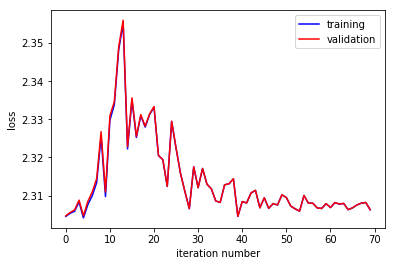

The loss on the  training data is  2.30629951559
The classification error rate on the training data is  0.9
The loss on the  validation data is  2.3063049152
The classification error rate on the validation data is  0.9
The loss on the  test data is  2.30629221879
The classification error rate on the test data is  0.9002222222222223
momentum 0.9 lr 1.0
Error! Theta element # 1642 , with value  0.046369533543 has finite difference gradient -0.00269888772205 but analytic gradient is -0.00239817218968 That looks like an error.
Error! Theta element # 623 , with value  0.0999375415997 has finite difference gradient -0.000629245939724 but analytic gradient is -0.000913382230768 That looks like an error.
Error! Theta element # 2264 , with value  0.0494715045845 has finite difference gradient 0.00129069669896 but analytic gradient is 0.000739631114562 That looks like an error.
Error! Theta element # 1245 , with value  0.0997502444198 has finite difference gradient -0.0009895107284 but analytic 

Error! Theta element # 213 , with value  -0.00574724308477 has finite difference gradient 3.89529835276e-05 but analytic gradient is 0.000191581795268 That looks like an error.
Error! Theta element # 1854 , with value  0.0857880551242 has finite difference gradient 0.000240479684702 but analytic gradient is -8.71666203671e-05 That looks like an error.
Error! Theta element # 835 , with value  -0.00927161757483 has finite difference gradient -0.000399695466356 but analytic gradient is -0.000524671245129 That looks like an error.
Error! Theta element # 2476 , with value  0.0839186304548 has finite difference gradient -0.000443521268771 but analytic gradient is -0.000707034815063 That looks like an error.
Error! Theta element # 1457 , with value  -0.0127844102569 has finite difference gradient -0.000609187460835 but analytic gradient is -0.00042181449915 That looks like an error.
Error! Theta element # 438 , with value  -0.0949668255372 has finite difference gradient -0.00216526418477 but 

After  21 optimization iterations, training data loss is 2.3372883016 , and validation data loss is  2.33728910282
After  28 optimization iterations, training data loss is 2.4145310708 , and validation data loss is  2.41453191829
After  35 optimization iterations, training data loss is 2.47927747581 , and validation data loss is  2.47927732329
After  42 optimization iterations, training data loss is 2.44948699809 , and validation data loss is  2.44948716154
After  49 optimization iterations, training data loss is 2.43458607524 , and validation data loss is  2.4345860548
After  56 optimization iterations, training data loss is 2.42828511524 , and validation data loss is  2.42828543225
After  63 optimization iterations, training data loss is 2.43462246872 , and validation data loss is  2.4346228609
After  70 optimization iterations, training data loss is 2.44089703079 , and validation data loss is  2.44089696616
Error! Theta element # 1298 , with value  0.0628408433132 has finite differe

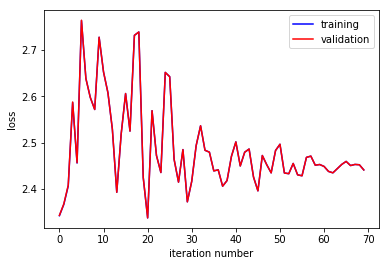

The loss on the  training data is  2.44089703079
The classification error rate on the training data is  0.9
The loss on the  validation data is  2.44089696616
The classification error rate on the validation data is  0.9
The loss on the  test data is  2.44089547537
The classification error rate on the test data is  0.9
momentum 0.9 lr 5.0


KeyboardInterrupt: 

In [ ]:
learning_rates = [0.002, 0.01, 0.05, 0.2, 1.0, 5.0, 20.0]
momentums = [0.0,0.9]
for momentum in momentums:
    for lr in learning_rates:
        print("momentum",momentum,"lr",lr)
        a3(0, 10, 70, lr, momentum, False, 4)